In [127]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import time

In [167]:
class LandScape():

    def __init__(self, N, K, K_within, K_between, state_num=2):
        self.N = N
        self.K = K
        self.K_within = K_within
        self.K_between = K_between
        
        self.IM_np = None
        self.state_num = state_num
        self.FC_np = None
        self.cache_np = [] # (1*2^N), using int(str) as the index
        self.cog_cache_np = [0] * (2**self.N)

    def create_influence_matrix(self):
        IM = np.eye(self.N)
        if self.K_within is None:
            for i in range(self.N):
                probs = [1 / (self.N - 1)] * i + [0] + [1 / (self.N - 1)] * (self.N - 1 - i)
                ids = np.random.choice(self.N, self.K, p=probs, replace=False)
                for index in ids:
                    IM[i][index] = 1
        else:
            for i in range(self.N):
                if i // (self.N // 2) < 1:
                    within = [j for j in range(self.N // 2)]
                    between = [j for j in range(self.N // 2, self.N)]
                    probs = [1 / (self.N // 2 - 1)] * i + [0] + [1 / (self.N // 2 - 1)] * (self.N // 2 - 1 - i)
                    ids_within = np.random.choice(within, self.K_within, p=probs, replace=False)
                    ids_between = np.random.choice(between, self.K_between, replace=False)
                    for index in ids_within:
                        IM[i][index] = 1
                    for index in ids_between:
                        IM[i][index] = 1

                else:
                    within = [j for j in range(self.N // 2, self.N)]
                    between = [j for j in range(self.N // 2)]
                    probs = [1 / (self.N // 2 - 1)] * (i - self.N // 2) + [0] + [1 / (self.N // 2 - 1)] * (
                                self.N - 1 - i)
                    ids_between = np.random.choice(between, self.K_between, replace=False)
                    ids_within = np.random.choice(within, self.K_within, p=probs, replace=False)
                    for index in ids_within:
                        IM[i][index] = 1
                    for index in ids_between:
                        IM[i][index] = 1
        self.IM_np = np.array(IM)
    
    def create_fitness_config_np(self,):
        self.FC_np = np.random.random((self.N, pow(self.state_num, self.K+1))) # (N by 2^(K+1))
    
    def calculate_fitness_np(self, state):
#         state = np.array(state)
        state = np.tile(state, (self.N, 1))
        index_matrix = state[self.IM_np.astype("bool")].reshape(self.N, -1)
        index_matrix = index_matrix.dot(self.state_num ** np.arange(index_matrix.shape[1])[::-1])
        res = np.average(self.FC_np[np.arange(self.N), index_matrix])
        return res
    
    def store_cache_np(self,):
#         self.cache_np = [self.calculate_fitness_np(each_state) for each_state in product(range(self.state_num), repeat=self.N)]
        all_states = [i for i in product(range(self.state_num), repeat=self.N)]
        for each_state in all_states:
            self.cache_np.append(self.calculate_fitness_np(each_state))
    
    def initialize_np(self, first_time=True, norm=True):
        if first_time:
            self.create_influence_matrix()
        self.create_fitness_config_np()
        self.store_cache_np()
        if norm:
            max_ = max(self.cache_np)
            min_ = min(self.cache_np)
            self.cache_np = [(i-min_)/(max_-min_) for i in self.cache_np]
        self.cog_cache_np = {}
    
    def query_fitness_np(self, state):
#         state = np.array(state)
        state_index = state.dot(2 ** np.arange(state.size)[::-1])
        return self.cache_np[state_index]

In [168]:
class Agent:
    
    def __init__(self, N, landscape):
        self.N = N
        self.state = np.random.choice([0, 1], self.N)
        self.landscape = landscape
        self.fitness_np = self.landscape.query_fitness_np(self.state)
        self.temp_state = None
    
    def adaptation_np(self, ):
        self.temp_state = self.state.copy() # 显式复制
        choice = np.random.choice(self.N)
        self.temp_state[choice]^= 1
        if self.landscape.query_fitness_np(self.state) < self.landscape.query_fitness_np(self.temp_state):
            self.state = self.temp_state.copy()
            self.fitness_np = self.landscape.query_fitness_np(self.temp_state)


In [171]:
np.random.seed(100)
gap_list = []
for i in range(5):
    start_time = time.time()
    N = 8
    ress = []
    for k in [0, 2, 4, 6]:
        res = []
        landscape = LandScape(N, k, None, None)
        landscape.initialize_np()
        for repeat in range(200):
            fitness = []
            agent = Agent(N, landscape)
            for step in range(100):
                agent.adaptation_np()
                fitness.append(agent.fitness_np)
            res.append(fitness)
        ress.append(res)
    end_time = time.time()
    gap = end_time - start_time
    gap_list.append(gap)


print("Average Running Time: ",sum(gap_list)/len(gap_list) )

Average Running Time:  1.7718281269073486


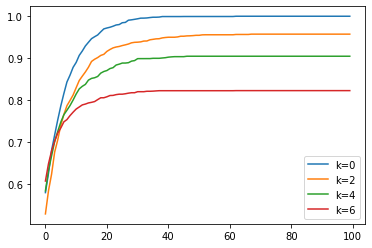

In [172]:
for k in range(4):
    plt.plot(np.mean(np.array(ress[k]),axis=0), label="k=%d"%(k*2))
plt.legend()